In [30]:
from nilearn import datasets, plotting, decomposition, regions, connectome
import numpy as np
import pandas as pd

In [31]:
patient_df = pd.read_csv("./patient_ids.csv")
ids = list(patient_df['ID'])

In [32]:
data = datasets.fetch_oasis_vbm(data_dir="./data/")

/usr/local/lib/python3.9/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [10]:
white_matter_maps = []
labels = []
for i in ids:
    for j in range(len(data.ext_vars)):
        if (str(data.ext_vars[j][0]).split('_')[1] == i.split('_')[1]):
            white_matter_maps.append(data.white_matter_maps[j])
            labels.append(data.ext_vars[j][7])

In [22]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', data_dir="./data/")
atlas_filename = dataset.maps
labels = dataset.labels

In [24]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(white_matter_maps)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]0.1s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


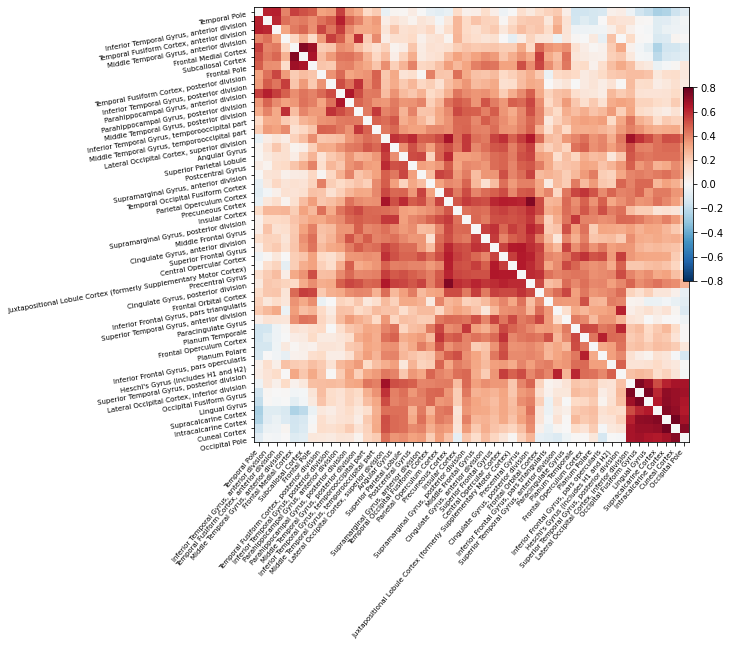

In [25]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

In [27]:
# Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(regions_img)

# Plot ROI Nodes
title = "Location of 55 ROI Nodes"
plotting.plot_markers(np.ones(n_regions), coords, colorbar=False, title=title)

NameError: name 'regions_img' is not defined